In [39]:
import io
import networkx as nx
import dimod
import numpy as np
import json
import smop
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
g = nx.read_shp('RUS_rds/RUS_roads.shp')

In [41]:
sgs = list(nx.connected_component_subgraphs(
    g.to_undirected()))
i = np.argmax([len(sg) for sg in sgs])
sg = sgs[i]

In [242]:
# pos = [(55.7367, 37.6986),  # Москва
#        (56.8520, 35.9225),  # Тверь
#        (57.6322, 39.8817),  # Ярославль
#        (56.3028, 43.9371),  # Нижний Новгород
#        (52.6030, 39.5755)]  # Липецк

# pos = [(55.7367, 37.6986), # Москва 
# (56.8520, 35.9225), # Тверь 
# (57.6322, 39.8817), # Ярославль 
# (56.3028, 43.9371), # Нижний Новгород 
# (52.6030, 39.5755), # Липецк
# (54.1919, 37.6168), # Тула
# (54.6293, 39.7369), # Рязань
# (51.6624, 39.1992), # Воронеж
# (50.5972, 36.5886), # Белгород
# (55.3984, 43.8410)] # Арзамас

# pos = [(55.7367, 37.6986), # Москва
#     (56.8520, 35.9225), # Тверь
#     (57.6322, 39.8817), # Ярославль
#     (52.6030, 39.5755), # Липецк
#     (56.3028, 43.9371), # Нижний Новгород
#     (54.1919, 37.6168), # Тула
#     (54.6293, 39.7369), # Рязань
#     (56.1203, 47.2728)]  # Чебоксары

pos = [(56.3106, 38.1311), # Сергиев Посад 
(56.7366, 38.8504), # Переславль-Залесский 
(57.1859, 39.4189), # Ростов Великий 
(57.6211, 39.8937), # Ярославль 
(57.7667, 40.9269), # Кострома 
(56.9970, 40.9761), # Иваново 
(56.4200, 40.4489), # Суздаль 
(56.1400, 40.4118), # Владимир
(56.3106, 38.1311)] # Сергиев Посад

In [243]:
points = nx.generators.classic.complete_graph(len(pos))

In [244]:
def get_path(n0, n1):
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

In [245]:
EARTH_R = 6372.8

def geocalc(lat0, lon0, lat1, lon1):
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

In [246]:
def get_path_length(path):
    return np.sum(geocalc(path[1:, 1], path[1:, 0],
                          path[:-1, 1], path[:-1, 0]))

In [247]:
def path_length(g, path):
    length = 0
    for x in range(len(path)-1):
        length += nx.shortest_path_length(
            g,
            source=path[x],
            target=path[x+1],
        weight = 'weight')
    return length

In [248]:
for n0, n1 in sg.edges:
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg.edges[n0, n1]['distance'] = distance

In [249]:
nodes = np.array(sg.nodes())
posi = []
for x in range(len(pos)):
    posi.append(np.argmin(np.sum((nodes[:, ::-1] - pos[x])**2, axis=1)))

In [250]:
def get_shortest_path(g, a, b):
    path = nx.shortest_path(
        g,
        source=tuple(nodes[posi[a]]),
        target=tuple(nodes[posi[b]]),
        weight='distance')
    return path

In [251]:
for a in range(len(posi)):
    for b in range(len(posi)):
        if a == b:
            continue
        length = (nx.shortest_path_length(
            sg,
            source=tuple(nodes[posi[a]]),
            target=tuple(nodes[posi[b]]),
            weight='distance'))
        points.add_edge(a, b, weight = length)

In [252]:
paths = nx.all_simple_paths(points, source = 0, target = len(pos)-1)
long_paths = []
for path in paths:
    if len(path) == len(points):
        long_paths.append([path, path_length(points,path)])
#         print(path, path_length(points,path))
min_p = long_paths[np.argmin(long_paths, axis=0)[1]]
min_path = np.array(min_p[:-1]).flatten()
print('min:', min_path)

min: [0 1 2 3 4 5 6 7 8]


In [253]:
full_path = []
pon = []
for x in range(len(min_path)-1):
    full_path += get_shortest_path(sg, min_path[x], min_path[x+1])[:-1]
    pon.append(len(full_path))

In [254]:
pmin = np.amin(pos, axis = 0)
pmax = np.amax(pos, axis = 0)
m = smop.Map(pmin, pmax, z=7)

In [255]:
def get_full_path(path, checkpoint = False):
    p_list = []
    pp = []
    curp = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if curp is None:
            curp = p
        if (np.sum((p[0] - curp) ** 2) >
                np.sum((p[-1] - curp) ** 2)):
            p = p[::-1, :]
        if i+1 in pon:
            pp.append(p[-1])
        p_list.append(p)
        curp = p[-1]
    if checkpoint:
        return np.vstack(pp)
    return np.vstack(p_list)

In [256]:
linepath = get_full_path(full_path)
popo = get_full_path(full_path, checkpoint=True)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])
a, b = m.to_pixels(popo[:, 1], popo[:, 0])

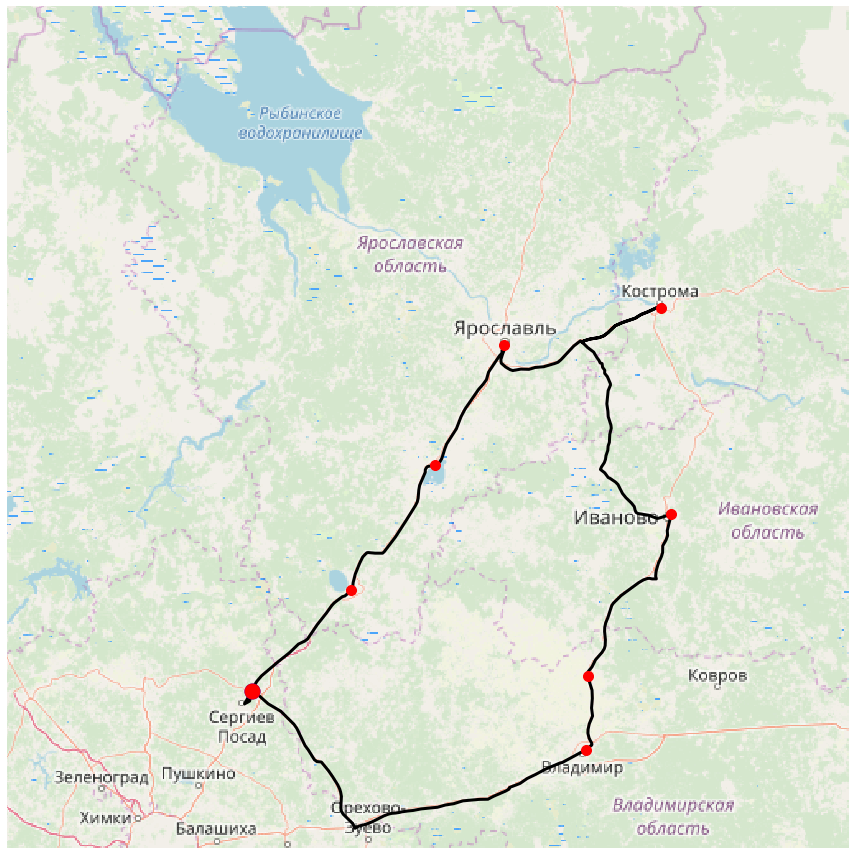

In [257]:
ax = m.show_mpl(figsize=(12, 12))

ax.plot(x, y, '-k', lw=3)

ax.plot(x[0], y[0], 'ob', ms=15)
ax.plot(x[-1], y[-1], 'or', ms=15)

for q in range(len(a)):
    ax.plot(a[q],b[q], 'or', ms=10)